5.813250639317658
12.736400204797832
49.698680517299444
66.20281864380966
21.080397079922534
79.69515353123397
90.0
27.734190504985406
46.30789560166377
47.082565279730886
68.81165425097275
39.63941656669704
53.2001460594988
12.49146931136579
34.80535388856475
43.23760897633949
54.02928963863201
79.55341055057119
50.43338119038532
10.353320043929443
21.80140948635181
46.76239102366051
62.85031830221685
15.771948056854853
71.02959219151346
75.96375653207353
51.666659890901364
38.388748043279236
64.732689499661
20.823905724923605
72.5528115767178
28.92642583525361
52.03180203930897
67.31944039297508
32.32433415160412
41.76029970389786
57.112622925985015
10.304846468766016
69.25391972431657
82.38806240328508
32.60728652305394
46.33610247089379
52.60577957438181
21.56297649104969
16.414688443398546
56.800772159818564
52.618546487568935
70.86635679409453
50.81009942771928
45.90938044919914
11.003540851749504
85.46996859581077
87.7245435617458
68.01393624661117
39.23011494212034
5.5098762596

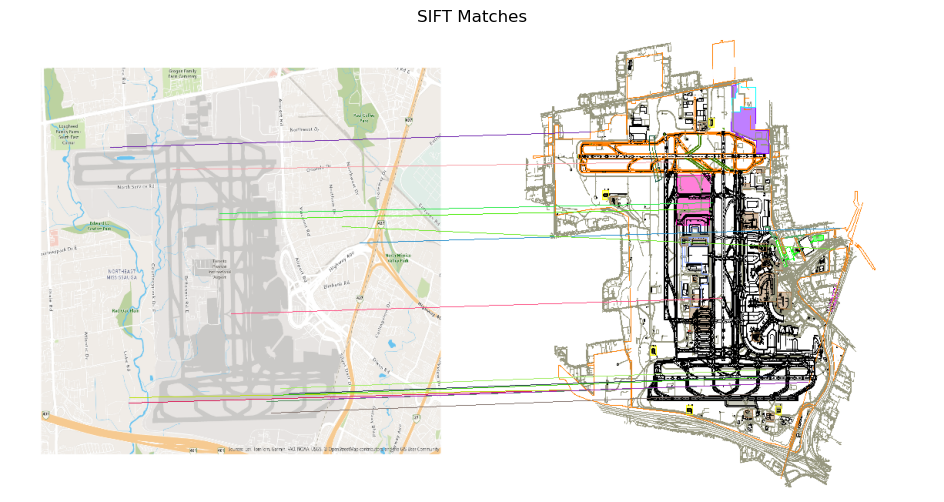

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import math

def preprocess_image(image, target_size=(600, 600)):
    """Reduce background noise while preserving main structures for both satellite and CAD images."""
    img_resized = cv2.resize(image, target_size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    binary = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, 15, 2)
    kernel = np.ones((3, 3), np.uint8)
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    return img_resized, gray, clean

def add_border(image, border_size=100):
    """Add a larger border around the image to exclude areas from matching."""
    return cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=(255, 255, 255))

def rotate_image(image, angle):
    """Rotate image by a given angle without cropping."""
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def match_edge_maps(edges1, edges2, method="ORB"):
    """Match keypoints using ORB or SIFT."""
    if method == "ORB":
        detector = cv2.ORB_create(nfeatures=1000)
    else:
        detector = cv2.SIFT_create()
    
    kp1, des1 = detector.detectAndCompute(edges1, None)
    kp2, des2 = detector.detectAndCompute(edges2, None)
    
    if des1 is None or des2 is None:
        return None, [], []
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING if method == "ORB" else cv2.NORM_L2, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)[:100]
    
    return matches, kp1, kp2

def calculate_angle(p1, p2):
    """Calculate the angle of the line between two points relative to the x-axis (in degrees),
    ensuring the result is between 0 and 90 degrees."""
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    angle = abs(math.atan2(dy, dx) * 180.0 / math.pi)  # Convert to degrees and ensure positive
    angle = min(angle, 180 - angle)  # Ensure it's within 0-90 degrees
    return angle

def calculate_distance(p1, p2):
    """Calculate the Euclidean distance between two points."""
    return np.linalg.norm(np.array(p2) - np.array(p1))

def filter_extreme_slope_and_long_matches(matches, kp1, kp2, max_angle=45, max_distance_ratio=0.1):
    """Filter matches to remove those with extreme slopes or excessive distances."""
    filtered_matches = []
    max_distance = 0  # To track the longest distance
    
    # First pass: calculate the maximum distance
    for match in matches:
        p1 = tuple(map(int, kp1[match.queryIdx].pt))
        p2 = tuple(map(int, kp2[match.trainIdx].pt))
        distance = calculate_distance(p1, p2)
        max_distance = max(max_distance, distance)
    
    # Second pass: filter based on slope and distance
    for match in matches:
        p1 = tuple(map(int, kp1[match.queryIdx].pt))
        p2 = tuple(map(int, kp2[match.trainIdx].pt))
        
        # Calculate the angle of the line formed by the match (p1, p2)
        angle = calculate_angle(p1, p2)
        
        # Calculate the Euclidean distance between the points
        distance = calculate_distance(p1, p2)
        
        # Keep match only if:
        # 1. The angle is less than the max_angle threshold (not too steep)
        # 2. The distance is within a certain ratio of the max distance (not too long)
        if abs(angle) <= max_angle and distance <= max_distance * max_distance_ratio:
            filtered_matches.append(match)
    
    return filtered_matches

def filter_quadrant_matches(matches, kp1, kp2, img1_shape, img2_shape):
    """Filter matches to ensure that points are within the same quadrant in both images."""
    h1, w1 = img1_shape[:2]  # Ignore the channel dimension
    h2, w2 = img2_shape[:2]  # Ignore the channel dimension
    
    valid_matches = []
    for match in matches:
        p1 = kp1[match.queryIdx].pt
        p2 = kp2[match.trainIdx].pt
        
        # Determine quadrants for both images
        quadrant1 = (p1[0] < w1 // 2, p1[1] < h1 // 2)
        quadrant2 = (p2[0] < w2 // 2, p2[1] < h2 // 2)
        
        # Keep match only if they are in the same quadrant
        if quadrant1 == quadrant2:
            valid_matches.append(match)
    
    return valid_matches

def visualize_matches(img1, kp1, img2, kp2, matches, title):
    """Draw and visualize matched keypoints side by side."""
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR) if len(img1.shape) == 2 else img1
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR) if len(img2.shape) == 2 else img2
    
    new_h, new_w = max(h1, h2), w1 + w2
    canvas = np.zeros((new_h, new_w, 3), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:w1+w2] = img2
    
    for match in matches:
        kp1_pt = kp1[match.queryIdx].pt
        kp2_pt = (kp2[match.trainIdx].pt[0] + w1, kp2[match.trainIdx].pt[1])
        color = tuple(random.randint(0, 255) for _ in range(3))
        cv2.line(canvas, tuple(map(int, kp1_pt)), tuple(map(int, kp2_pt)), color, 1)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

satellite_path = r"C:\Users\User\Downloads\TIFF GTAA Georeferenced (1)\TIFF GTAA Georeferenced\community.tif"
cad_path = r"C:\Users\User\Downloads\6414_Test\GTAA_ungeoreferenced.tif"
img1 = cv2.imread(satellite_path)
img2 = cv2.imread(cad_path)

# Add a larger border around the satellite image
border_size = 100
img1_with_border = add_border(img1, border_size)
img2_with_border = add_border(img2, border_size)

img1_processed, gray1, edges1 = preprocess_image(img1_with_border)
img2_processed, gray2, edges2 = preprocess_image(img2_with_border)

best_matches, best_kp1, best_kp2, best_angle = [], [], [], 0
for angle in range(0, 360, 10):
    edges2_rot = rotate_image(edges2, angle)
    matches, kp1, kp2 = match_edge_maps(edges1, edges2_rot, method="ORB")
    if matches and len(matches) > len(best_matches):
        best_matches, best_kp1, best_kp2, best_angle = matches, kp1, kp2, angle

# Filter matches to ensure they are in the same quadrant
best_matches = filter_quadrant_matches(best_matches, best_kp1, best_kp2, img1.shape, img2.shape)

# Filter for extreme slopes and long distances
best_matches = filter_extreme_slope_and_long_matches(best_matches, best_kp1, best_kp2, max_angle=45, max_distance_ratio=0.1)

#visualize_matches(img1_processed, best_kp1, img2_processed, best_kp2, best_matches, f"ORB Best Match at {best_angle}°")

matches_sift, kp1_sift, kp2_sift = match_edge_maps(edges1, edges2, method="SIFT")
if matches_sift:
    #matches_sift = filter_quadrant_matches(matches_sift, kp1_sift, kp2_sift, img1.shape, img2.shape)
    matches_sift = filter_extreme_slope_and_long_matches(matches_sift, kp1_sift, kp2_sift, max_angle=45, max_distance_ratio=0.1)
    visualize_matches(img1_processed, kp1_sift, img2_processed, kp2_sift, matches_sift, "SIFT Matches")


In [49]:
import cv2
import numpy as np
import arcpy
import os
import time
import uuid

def extract_matched_points(matches, kp1, kp2):
    """Extract (x, y) coordinates from matched keypoints."""
    cad_points = np.array([kp1[m.queryIdx].pt for m in matches])  # CAD image
    map_points = np.array([kp2[m.trainIdx].pt for m in matches])  # Map image
    return cad_points, map_points

def transform_map_point_to_geospatial(px, py, tfw_params):
    """Convert pixel coordinates (px, py) in the map image to geospatial coordinates using TFW."""
    A, D, B, E, C, F = tfw_params
    geo_x = A * px + B * py + C
    geo_y = D * px + E * py + F
    return geo_x, geo_y

def compute_dwg_bounding_box(dwg_path):
    """Extract the DWG bounding box (minX, maxX, minY, maxY) using ArcPy."""
    desc = arcpy.Describe(dwg_path)
    extent = desc.extent
    return extent.XMin, extent.XMax, extent.YMin, extent.YMax

def transform_cad_to_dwg(px, py, cad_size, dwg_bbox):
    """Convert pixel coordinates in the CAD image to DWG coordinate system."""
    minX, maxX, minY, maxY = dwg_bbox
    img_width, img_height = cad_size
    scale_x = (maxX - minX) / img_width
    scale_y = (maxY - minY) / img_height
    dwg_x = minX + px * scale_x
    dwg_y = maxY - py * scale_y  # Flip Y-axis
    return dwg_x, dwg_y

def read_tfw(tfw_path):
    with open(tfw_path, "r") as f:
        values = [float(line.strip()) for line in f.readlines()]
    return values  # [A, D, B, E, C, F]

def georeference_cad(dwg_path, control_points, output_gdb, output_shp):
    """Use control points to georeference CAD and convert to GIS format."""
    dwg_path = r"C:\Users\User\Downloads\GTAA 2.dwg"
    desc = arcpy.Describe(dwg_path)
    spatial_ref = desc.spatialReference

    fc_name = f"control_points_{uuid.uuid4().hex[:8]}"
    control_points_fc = os.path.join(output_gdb, fc_name)
    print(control_points_fc)

    if arcpy.Exists(control_points_fc):
        arcpy.Delete_management(control_points_fc)

    print("Contents of GDB:")
    arcpy.env.workspace = output_gdb
    print(arcpy.ListFeatureClasses())

    arcpy.env.workspace = output_gdb
    result = arcpy.CreateFeatureclass_management(
        output_gdb,
        fc_name,
        "POINT",
        spatial_reference=spatial_ref
    )

    print("Feature class created at:", result)
    print("Exists immediately after creation?", arcpy.Exists(control_points_fc))
    time.sleep(5)

    print("Exists?", arcpy.Exists(control_points_fc))
    
    with arcpy.da.InsertCursor(control_points_fc, ['SHAPE@XY']) as cursor:
        for dwg_pt, geo_pt in control_points:
            print("Inserting point:", dwg_pt)
            cursor.insertRow([(dwg_pt[0], dwg_pt[1])])
    
    # Convert CAD to GIS
    arcpy.CADToGeodatabase_conversion(
        dwg_path,
        output_gdb,
        "cad_features",
        "1",  # reference scale as string
        spatial_ref
    )
    # Ensure you're pointing to the correct feature class
    cad_features_fc = os.path.join(output_gdb, "Polyline")  # Update as per your actual data
    
    # Check the list of feature classes imported
    print(arcpy.ListFeatureClasses(feature_dataset="cad_features"))
    
    # Export GIS data to a Shapefile
    arcpy.conversion.FeatureClassToShapefile(cad_features_fc, output_shp)

def main(dwg_path, map_image, cad_image, tfw_path, matches, kp1, kp2, output_gdb, output_shp):
    """Main function to process matches and georeference CAD to GIS."""
    # Step 1: Extract matched pixel coordinates
    cad_points, map_points = extract_matched_points(matches, kp1, kp2)
    
    # Step 2: Compute the original size of images
    cad_size = cad_image.shape[1], cad_image.shape[0]  # (width, height)
    map_size = map_image.shape[1], map_image.shape[0]
    
    # Step 3: Convert map points to geospatial coordinates
    tfw_params = read_tfw(tfw_path)
    geospatial_points_map = [transform_map_point_to_geospatial(x, y, tfw_params) for x, y in map_points]
    
    # Step 4: Compute DWG bounding box
    dwg_bbox = compute_dwg_bounding_box(dwg_path)
    
    # Step 5: Convert CAD points to DWG coordinates
    dwg_points = [transform_cad_to_dwg(x, y, cad_size, dwg_bbox) for x, y in cad_points]
     
    # Step 6: Create control points and georeference the CAD file
    control_points = list(zip(dwg_points, geospatial_points_map))
    georeference_cad(dwg_path, control_points, output_gdb, output_shp)
    
    print("Georeferencing complete. CAD converted to GIS format and shapefile exported.")


In [50]:
output_gdb = r"C:\Users\User\Downloads\NEW_GTAA\output.gdb"

if not arcpy.Exists(output_gdb):
    arcpy.CreateFileGDB_management(out_folder_path=os.path.dirname(output_gdb),
                                    out_name=os.path.basename(output_gdb))
    
dwg_path = r"C:\Users\User\Downloads\GTAA 2.dwg"
desc = arcpy.Describe(dwg_path)
print(desc.spatialReference.name)
print(desc.spatialReference.factoryCode)
    
main(dwg_path = r"C:\Users\User\Downloads\GTAA 2.dwg",
     map_image=cv2.imread(satellite_path),
     cad_image=cv2.imread(cad_path),
     tfw_path= r"C:\Users\User\Downloads\TIFF GTAA Georeferenced (1)\TIFF GTAA Georeferenced\community.tfw",  # Extract these from the TFW file
     matches=matches_sift, 
     kp1=kp1_sift, 
     kp2=kp2_sift,
     output_gdb=output_gdb,
     output_shp=r"C:\Users\User\Downloads\output_shapefile")


NAD_1927_UTM_Zone_17N
26717
C:\Users\User\Downloads\NEW_GTAA\output.gdb\control_points_eb1822fa
Contents of GDB:
['control_points_bf4af3f5', 'control_points_b0a531f3', 'control_points_8e233c6b', 'control_points_bddd3864', 'control_points_fa708e52', 'control_points_d5e11a39', 'control_points_8a75aa7c', 'control_points_018d66b1']
Feature class created at: C:\Users\User\Downloads\NEW_GTAA\output.gdb\control_points_eb1822fa
Exists immediately after creation? True
Exists? True
Inserting point: (57413.57214846005, 9206984.254815763)
Inserting point: (58365.507738023174, 9193167.405963823)
Inserting point: (26536.436378084974, 9205240.24182768)
Inserting point: (46908.804194351076, 9443727.22859942)
Inserting point: (26712.178656030046, 9211885.29272134)
Inserting point: (46680.068440453746, 9435595.805350656)
Inserting point: (58365.507738023174, 9193167.405963823)
Inserting point: (70873.28004225645, 9210682.181740034)
Inserting point: (46680.068440453746, 9435595.805350656)
Inserting point